- *datatime:* метка времени + дата, к который относится каждый час суток
- *season:* сезон [1. весна 2. лето 3. осень 4. зима]
- *holiday:* считается ли день праздником. В исходных данных [0. нет 1. да]
- *weather:* погода [1. ясно, небольшая облачность, частичная облачность 2. туман + облачность, туман + разорванные облака, туман + небольшая облачность, туман 3. легкий снег, дождь + гроза + переменная облачность, небольшой дождь + вероятна облачность 4. сильный дождь + ледяной дождь + гроза + туман, снег + тумат]
- *temp:* температура в градусах Цельсия (показания датчиков)
- *atemp:* "Ощущаемая" температура в градусах Цельсия 
- *humidity:* относительная влажность
- *windspeed:* скорость ветра
- *workingday:* отметка, если день не выходной и не праздник  
- *casual:* количество незарегистрированных пользователей аренды
- *registered:* количество зарегистрированных пользователей аренды
- *count:* общее количество аренды

### Постановка задачи: <br>
Необходимо спрогнозировать спрос на велосипеды (признаки casual, registred, count).

Разработанная модель может помочь выявить наиболее значимые признаки в прогнозировании спроса на прокатные велосипеды разных типов пользователей.

* casual - это незарегестрированные пользователи, которые, возможно, редко пользуются прокатом и им не выгодно оформлять абонемент
* registred - это пользователи, которые завели себе абонемент
* count - registred+casual

Соответственно целевой переменной может быть любое из этих вариантов

Качество оценивается c помощью Root Mean Squared Logarithmic Error (RMSLE) - то есть недопрогноз в данном случае хуже, чем перепрогноз

In [1]:
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.float_format', lambda x: '%.1f' % x)

%matplotlib inline

### Загрузка и предобработка данных

In [2]:
df = pd.read_csv('/Users/dergilev/Desktop/lesson 4/lesson_04_homework/train_bikes.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.8,14.4,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.0,13.6,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.0,13.6,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.8,14.4,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.8,14.4,75,0.0,0,1,1


In [3]:
print ('info', df.info())
print ('shape', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
info None
shape (10886, 12)


In [4]:
# Дата в формате строк. Переведем ее в формат дат.
# Сделаем разбивку даты по отдельным столбцам. (Год | Месяц | День | Час | День недели)

In [5]:
def get_date_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M')
    df['year'] = df.loc[:, 'datetime'].dt.year
    df['month'] = df.loc[:, 'datetime'].dt.month
    df['day'] = df.loc[:, 'datetime'].dt.day
    df['hour'] = df.loc[:, 'datetime'].dt.hour
    df['weekday'] = df.loc[:, 'datetime'].dt.weekday
    
    return df

In [6]:
df = df.pipe(get_date_features)

In [7]:
df.head()
df.shape

(10886, 17)

### Первичный анализ признаков:

In [8]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
count,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0,10886.0
mean,2.5,0.0,0.7,1.4,20.2,23.7,61.9,12.8,36.0,155.6,191.6,2011.5,6.5,10.0,11.5,3.0
std,1.1,0.2,0.5,0.6,7.8,8.5,19.2,8.2,50.0,151.0,181.1,0.5,3.4,5.5,6.9,2.0
min,1.0,0.0,0.0,1.0,0.8,0.8,0.0,0.0,0.0,0.0,1.0,2011.0,1.0,1.0,0.0,0.0
25%,2.0,0.0,0.0,1.0,13.9,16.7,47.0,7.0,4.0,36.0,42.0,2011.0,4.0,5.0,6.0,1.0
50%,3.0,0.0,1.0,1.0,20.5,24.2,62.0,13.0,17.0,118.0,145.0,2012.0,7.0,10.0,12.0,3.0
75%,4.0,0.0,1.0,2.0,26.2,31.1,77.0,17.0,49.0,222.0,284.0,2012.0,10.0,15.0,18.0,5.0
max,4.0,1.0,1.0,4.0,41.0,45.5,100.0,57.0,367.0,886.0,977.0,2012.0,12.0,19.0,23.0,6.0


In [9]:
print(df.shape)
df.describe().T

(10886, 17)


,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.5,1.1,1.0,2.0,3.0,4.0,4.0
holiday,10886.0,0.0,0.2,0.0,0.0,0.0,0.0,1.0
workingday,10886.0,0.7,0.5,0.0,0.0,1.0,1.0,1.0
weather,10886.0,1.4,0.6,1.0,1.0,1.0,2.0,4.0
temp,10886.0,20.2,7.8,0.8,13.9,20.5,26.2,41.0
atemp,10886.0,23.7,8.5,0.8,16.7,24.2,31.1,45.5
humidity,10886.0,61.9,19.2,0.0,47.0,62.0,77.0,100.0
windspeed,10886.0,12.8,8.2,0.0,7.0,13.0,17.0,57.0
casual,10886.0,36.0,50.0,0.0,4.0,17.0,49.0,367.0
registered,10886.0,155.6,151.0,0.0,36.0,118.0,222.0,886.0


#### Категориальные признаки

In [10]:
for i in ["holiday", "season", "weather", "workingday"]:
    print('')
    print(i)
    print(df[i].value_counts())
    print('_____________________________________________')


holiday
0    10575
1      311
Name: holiday, dtype: int64
_____________________________________________

season
4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64
_____________________________________________

weather
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
_____________________________________________

workingday
1    7412
0    3474
Name: workingday, dtype: int64
_____________________________________________


**Вывод:** <br>
Чаще велосипеды брали в ясную погоду. Присутствует редкая категория "4" в признаке "weather". <br>

#### Анализ линейных зависимостей в данных

Определим, есть ли переменные с высокой корреляцией.

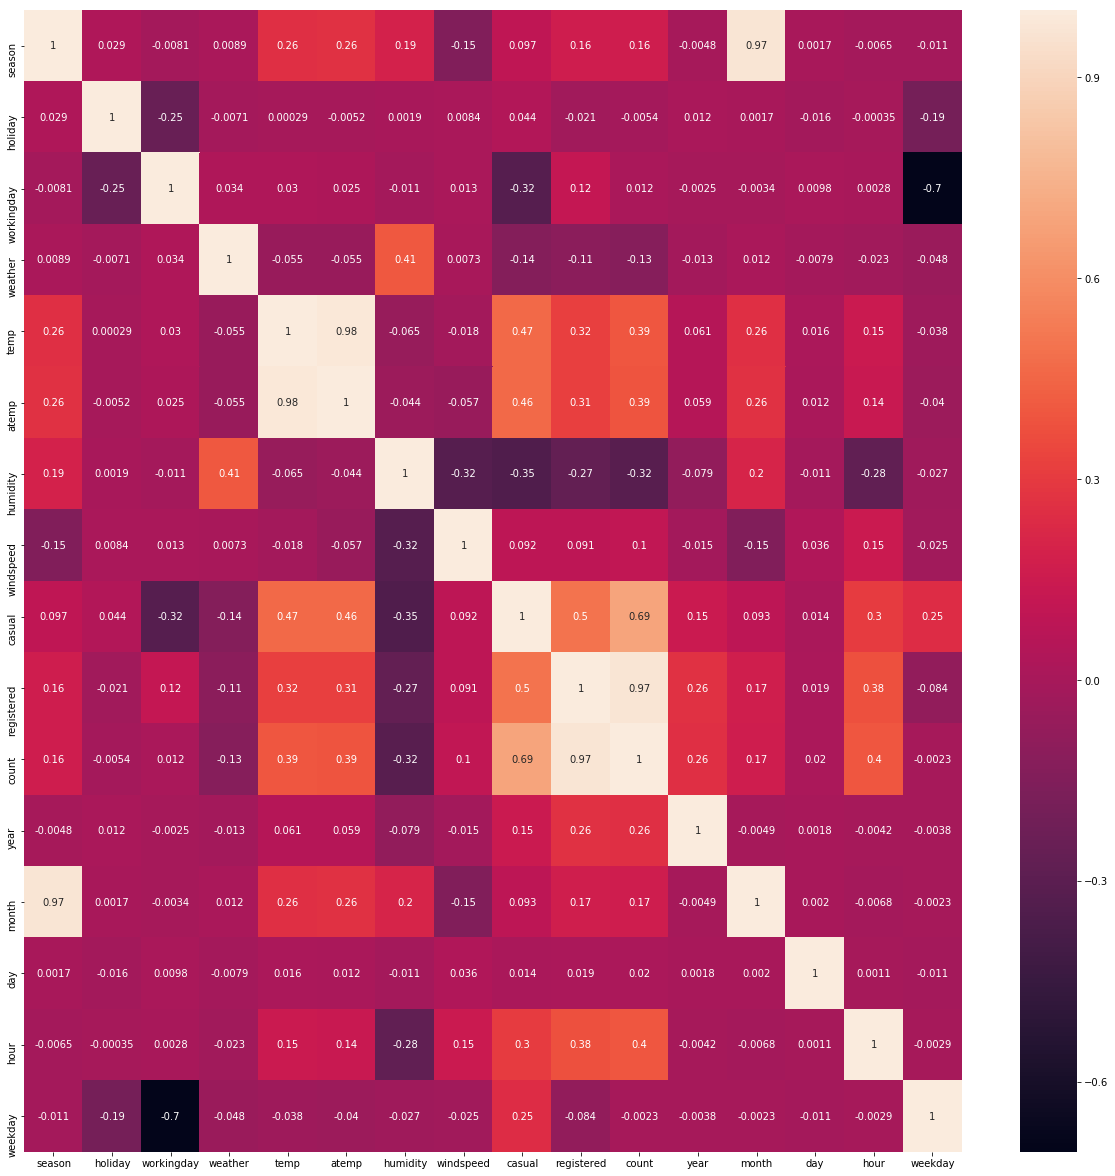

In [11]:
f, ax = plt.subplots(figsize = (21, 21))
sns.heatmap(df.corr(), ax = ax, annot=True)

**Вывод:** <br>
Имеют наибольшую корреляцию между собой следующие признаки:
1. [0.98] atemp и temp
2. [0.97] count и registred
3. [0.97] month и weekday 
4. [0.97] month и season
5. [-0.7] weekday и workingday
6. [0.69] count и casual

Можем удалить: atemp, registred, casual, weekday, season


#### Распределение некоторых признаков

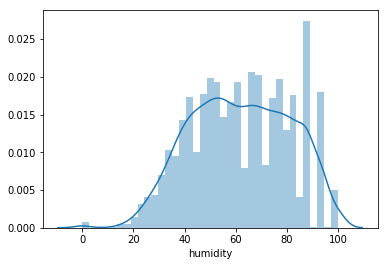

In [12]:
# относительная влажность
sns.distplot(df['humidity'])

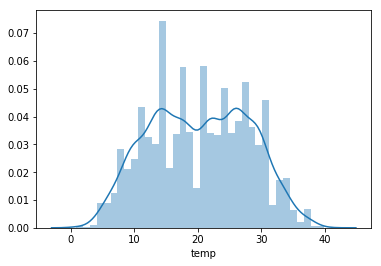

In [13]:
sns.distplot(df['temp'])

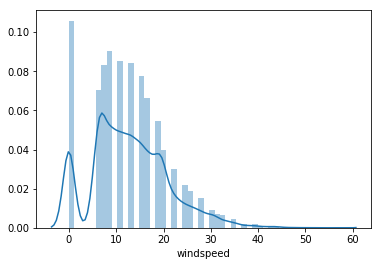

In [14]:
sns.distplot(df['windspeed'])

#### Парные распределения с целевыми признаками

*Выясним, как зависит аренда от даты и времени.*

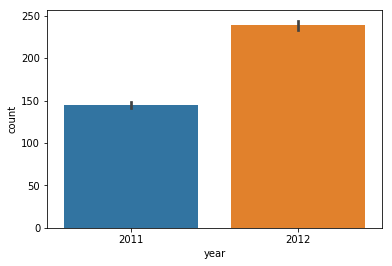

In [15]:
sns.barplot('year', 'count', data=df)

**Вывод:** <br>
Количество аренды возврасло в течение заданного периода (2011 - 2012 года). Стоит это учитывать при прогнозировании на дни соответствующих годов.

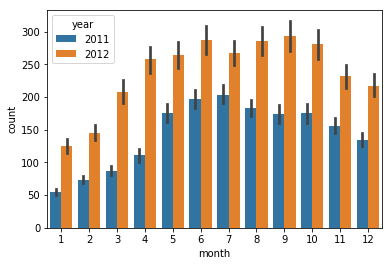

In [16]:
sns.barplot('month', 'count', data=df, hue='year')

**Вывод:** <br>
В зимний период наблюдался спад востребованности велосипедов, а в летние - напротив, рост. То есть прослеживается очевидная сезонность.

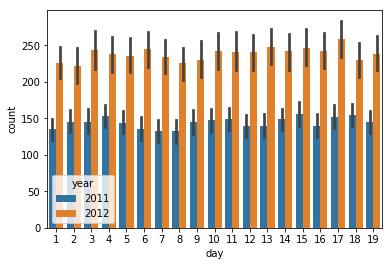

In [17]:
sns.barplot('day', 'count', data=df, hue='year')

**Вывод:** <br>
Можно сделать вывод, что ежедневная востребованность велосипедов в первой половине месяца не имела тенденции резко возрастать или уменьшаться. <br>
То есть данные о дне не имеют высокого влияния на аренду.

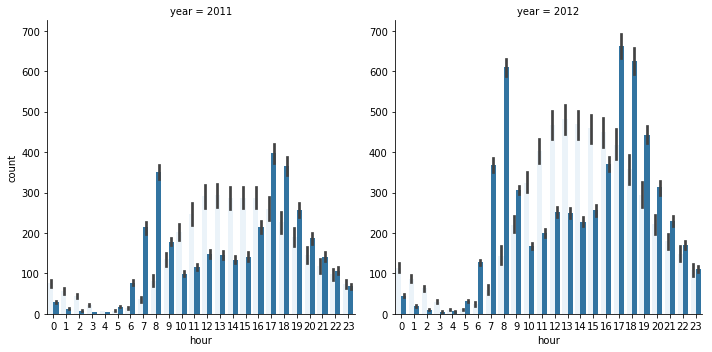

In [18]:
g = sns.FacetGrid(df, col='year', size=5)
g.map(sns.barplot, 'hour', 'count', 'workingday')

**Вывод:** <br>
В отличие от дня на календаре время имеет вес в прогнозировании. После возрастания (и последующего падения) в утренние часы, к вечеру количество арендующих постепенно возрастало.

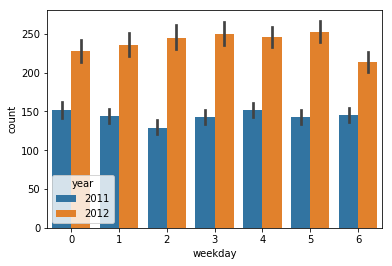

In [19]:
sns.barplot('weekday', 'count', data=df, hue='year')

**Вывод:** <br>
Наблюдался небольшой провал в воскресение.

Посмотрим на отличие в распределение зарегистрированных и незарегистрированных пользователей

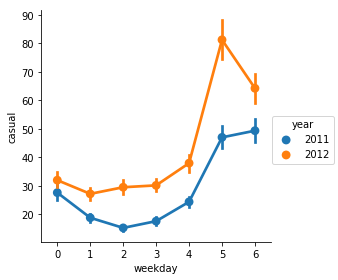

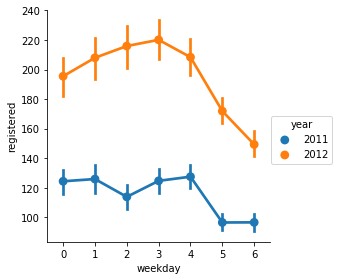

In [20]:
sns.factorplot('weekday', 'casual', data=df, hue='year')
sns.factorplot('weekday', 'registered', data=df, hue='year')

**Вывод: **<br>
Зарегистрированные в системе пользователи чаще брали велосипеды в выходные дни, при этом пик аренды достигался в субботу. <br>
Незарегистированные же предпочитали брать велосипеды в буднии дни, практически игнорируя(в сравнении) при этом выходные дни. Самый низкий показатель датировался воскресением, после чего в понедельник происходил резкий взлёт аренды. <br>

# Getting hands dirty

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

### Задание (0.25)

Создайте переменную (именно отдельную переменную а не стобец в датафрейме) состоящий из строк вида "год-месяц-час"
Эта переменная понадобится нам далее

In [22]:
df["year_month_hour"] = df["year"].map(str) + '-' + df["month"].map(str) + '-' + df["hour"].map(str)

### Задание (0.25)

Напишите функцию `prepare_features` которая бы
* Удаляла ненужные признаки (сильно скоррелированные и просто бесполковые, типа `datetime`, `day`)
* Оставляла только один из целевых признаков (casual, registred или count)
* Вместо того, чтобы затачиваться на конкретный час (признак `hour`) создайте новую переменную (утро, день, вечер, ночь). 
* Границы оцените интуитивно. Старую переменную удалите
* Преобразовывала бинарные признаки в вектора с {0,1} а категориальные признаки в вектора с {0,1,...,C-1}
* Опционально: создайте переменную, которая учитывает день недели и время

In [26]:
def prepare_features(df_input):
    
    df_input = df.loc[(df['hour'] >= 0) & (df['hour'] < 6), 'part_of_day'] = 'night'
    df_input = df.loc[(df['hour'] >= 6) & (df['hour'] < 12), 'part_of_day'] = 'morning'
    df_input = df.loc[(df['hour'] >= 12) & (df['hour'] < 18), 'part_of_day'] = 'day'
    df_input = df.loc[(df['hour'] >= 18) & (df['hour'] <= 24), 'part_of_day'] = 'evening'
    df_input = pd.get_dummies(df, columns=['part_of_day'])
    df_input = df['day-time'] = df['day'].map(str) + '-' + df['hour'].map(str)
    df_input = df.drop(['atemp', 'registered', 'casual', 'weekday', 'season', 'datetime', 'hour', 'day'], axis=1)
    
    return df_input

In [27]:
df_clean = df.pipe(prepare_features)

In [28]:
df_clean.head()

,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,year_month_hour,part_of_day,day-time
0,0,0,1,9.8,81,0.0,16,2011,1,2011-1-0,night,1-0
1,0,0,1,9.0,80,0.0,40,2011,1,2011-1-1,night,1-1
2,0,0,1,9.0,80,0.0,32,2011,1,2011-1-2,night,1-2
3,0,0,1,9.8,75,0.0,13,2011,1,2011-1-3,night,1-3
4,0,0,1,9.8,75,0.0,1,2011,1,2011-1-4,night,1-4


In [29]:
df_clean['weather'].replace(to_replace = 4, value="0", inplace=True)
df_clean['weather'] = df_clean.weather.astype('int64')

In [30]:
y = list(df_clean['count'])

Сделаем не простое разбиение на обучение и контроль а такую, что в контрольной и обучающей выборке будет примерно одинаковое распределение по году-месяцу

In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
holiday            10886 non-null int64
workingday         10886 non-null int64
weather            10886 non-null int64
temp               10886 non-null float64
humidity           10886 non-null int64
windspeed          10886 non-null float64
count              10886 non-null int64
year               10886 non-null int64
month              10886 non-null int64
year_month_hour    10886 non-null object
part_of_day        10886 non-null object
day-time           10886 non-null object
dtypes: float64(2), int64(7), object(3)
memory usage: 1020.6+ KB


In [33]:
df_clean = df_clean.drop(['year_month_hour', 'day-time'], axis=1)

In [34]:
df_clean

,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,part_of_day
0,0,0,1,9.8,81,0.0,16,2011,1,night
1,0,0,1,9.0,80,0.0,40,2011,1,night
2,0,0,1,9.0,80,0.0,32,2011,1,night
3,0,0,1,9.8,75,0.0,13,2011,1,night
4,0,0,1,9.8,75,0.0,1,2011,1,night
5,0,0,2,9.8,75,6.0,1,2011,1,night
6,0,0,1,9.0,80,0.0,2,2011,1,morning
7,0,0,1,8.2,86,0.0,3,2011,1,morning
8,0,0,1,9.8,75,0.0,8,2011,1,morning
9,0,0,1,13.1,76,0.0,14,2011,1,morning


### Задание (0.10)

Составьте pipeline, который состоит из следующих этапов (в скобках узакано "название" этапа):

* One-hot encoder ("onehot")
* StandartScaler ("scaler")
* ElasticNet ("elastic")

In [35]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

Для удобства будем использовать не LinearRegression а ElasticNet, так как в нем можно одновременно котроллировать оба типа регуляризации

In [36]:
# alpha - это общая сила регуляризации
# l1_ration - доля, которая приходтися на Lasso регуляризацию. Соответственно остальное идет на Rigde

In [37]:
one_hot = OneHotEncoder(categorical_features=[9])

In [38]:
standart = StandardScaler(with_mean=False)

In [39]:
regressor = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [40]:
model = Pipeline([
    ('onehot', one_hot),
    ('scaler', standart),
    ('elastic', regressor)
                ])

In [41]:
#df_clean = pd.get_dummies(df_clean, columns=['part_of_day'])

In [42]:
df_clean

,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,part_of_day
0,0,0,1,9.8,81,0.0,16,2011,1,night
1,0,0,1,9.0,80,0.0,40,2011,1,night
2,0,0,1,9.0,80,0.0,32,2011,1,night
3,0,0,1,9.8,75,0.0,13,2011,1,night
4,0,0,1,9.8,75,0.0,1,2011,1,night
5,0,0,2,9.8,75,6.0,1,2011,1,night
6,0,0,1,9.0,80,0.0,2,2011,1,morning
7,0,0,1,8.2,86,0.0,3,2011,1,morning
8,0,0,1,9.8,75,0.0,8,2011,1,morning
9,0,0,1,13.1,76,0.0,14,2011,1,morning


In [43]:
model.fit(df_clean, y)

ValueError: could not convert string to float: 'evening'

### Задание (0.15)

Перед тем как пойдем дальше реализуем RLMSE

In [ ]:
def rlmse_score(y_test, y_hat):
    # Your code here
    
    return rlmse

# Эту функцию трогать не надо
def rlmse_scorer(estimator, X, y):
    y_hat = estimator.predict(X)
    
    return rlmse_score(y, y_hat)

Так как мы еще не знаем, что такое GridSearch или RandomSearch будем исследоать изменение качества только одного из параметров: alpha

Сделаем мы это чуть более хитро чем просто в цикле перебирать разные значения:
* Во-первых мы сделаем особую кросс-валидацию, учитывающую время
* Так как у нас будет кросс-валидация, то мы сможем посмотреть на "стабильность" скора, а не просто на его среднее

In [51]:
from sklearn.model_selection import validation_curve

In [ ]:
# Это не обычная кросс-валидация а стратифицированная. №
# С ее помощью мы добъемся того, что в обучающем и валидационном фолде будет одна и та же пропорция годов-месяцев-часов
# Тут то и понадобится нам year_month_hour
# Подробности http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

# Переберем 20 значений в интервале от 10^-3 до 10^5
alpha_range = np.logspace(-3, 5, 20)

param_name = "elastic__alpha"
# пишем не просто alpha, потому что у нас pipeline и sklearn должен как-то понимать параметр какого этапа мы перебираем

train_scores, valid_scores = validation_curve(model, df_clean, y, param_name=param_name, param_range=alpha_range,
                                              cv=cv.split(df_clean, year_month_hour), scoring=rlmse_scorer)

# На выходе мы получим 2 матрицы размера 20 на n_folds
# Потому что у нас было 5 фолдов и 20 возможных значений гиперпараметра
# А матриц 2, потому что в каждом фолде есть обучающая и валидационная часть

### Задание (0.25)

Для каждой матрицы сделайте следующее

* По каждой строчке посчитайте среднее значение (среднее значение качества по заданного значения параметра)
* По каждой строчке посчитайте стандартное отклонение (мера разброса меры качества)

Изобразите график, на котором 
* по оси x отложены значения alpha
* по оси y отложены средние значения меры качества (отдельно для обучающей части и валидационной)
* с помощью функции plt.fill_between изобразите разбос меры качества в каждой точке (придется чутка почитать документации)